In [1]:
import bayesflow as bf
import tensorflow_probability as tfp
import tensorflow as tf
import numpy as np
import torch
from torch.distributions import Normal, Independent,InverseGamma

import rpy2.robjects as robjects
import numpy as np

/opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import subprocess

# 检查最新的 BayesFlow 版本
latest_version_cmd = "pip index versions bayesflow"
latest_version_result = subprocess.run(latest_version_cmd, shell=True, capture_output=True, text=True)

# 检查当前安装的 BayesFlow 版本
installed_version_cmd = "pip show bayesflow"
installed_version_result = subprocess.run(installed_version_cmd, shell=True, capture_output=True, text=True)

# 输出版本信息
latest_version_output = latest_version_result.stdout if latest_version_result.returncode == 0 else "Failed to fetch latest version."
installed_version_output = installed_version_result.stdout if installed_version_result.returncode == 0 else "BayesFlow is not installed."

latest_version_output, installed_version_output


('bayesflow (1.1.6)\nAvailable versions: 1.1.6, 1.1.5, 1.1.4, 1.1.3, 1.1.2, 1.1.1\n  INSTALLED: 1.1.6\n  LATEST:    1.1.6\n',
 'Name: bayesflow\nVersion: 1.1.6\nSummary: "Amortizing Bayesian Inference With Neural Networks"\nHome-page: https://github.com/stefanradev93/bayesflow\nAuthor: The BayesFlow Developers\nAuthor-email: \nLicense: MIT\nLocation: /opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages\nRequires: aesara, h5py, matplotlib, numpy, pandas, scikit-learn, scipy, seaborn, tensorflow, tensorflow-probability, tqdm\nRequired-by: \n')

In [3]:
import rpy2.robjects as robjects
import numpy as np

# 从 R 中加载数据
robjects.r('load("SpainPROV_CerebrovascularDiseases.Rdata")')

Rs = robjects.r('as.matrix(Rs)')

# 将 Rs 转换为 NumPy 数组
Rs_numpy = np.array(Rs)

# 检查矩阵的维度
print("Rs_numpy shape:", Rs_numpy.shape)


Rs_numpy shape: (47, 47)


In [4]:
# 计算特征分解
eigenvalues, eigenvectors = np.linalg.eig(Rs_numpy)

# 打印特征值和特征向量
print("Eigenvalues:", eigenvalues)
print("Eigenvectors:", eigenvectors)

# 计算协方差矩阵 Q
Q = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T  # Q = V * D * V.T
print("Covariance matrix Q:", Q)


Eigenvalues: [4.02898372e+00 3.91760840e+00 1.16270678e-16 8.70103967e-02
 1.36471249e-01 3.68894189e+00 2.84373915e-01 3.35903480e-01
 4.24394939e-01 3.57526766e+00 3.48700471e+00 5.49480100e-01
 6.86479773e-01 3.28806127e+00 3.24627671e+00 3.22501234e+00
 8.25429149e-01 9.23508897e-01 9.38544804e-01 1.00121440e+00
 1.08337936e+00 3.09257535e+00 1.18549682e+00 1.31239606e+00
 1.37151192e+00 1.41839871e+00 1.47548171e+00 2.94744613e+00
 2.90831092e+00 2.81326532e+00 2.78203196e+00 2.70367067e+00
 2.65184367e+00 2.55747008e+00 2.53141064e+00 2.45001418e+00
 2.38822842e+00 2.32899568e+00 2.26667887e+00 2.10897083e+00
 2.09243660e+00 1.96124040e+00 1.90970136e+00 1.87819751e+00
 1.75053418e+00 1.68927737e+00 1.71788199e+00]
Eigenvectors: [[ 0.09193583  0.12350732 -0.14586499 ...  0.16560432  0.01980325
   0.00368928]
 [ 0.05232506 -0.14409124 -0.14586499 ...  0.07575858 -0.08023009
   0.07457773]
 [-0.00563195  0.02052873 -0.14586499 ... -0.04477425  0.08674872
  -0.07251008]
 ...
 [ 0.07

In [5]:
eigenvalues, _ = np.linalg.eig(Q)
print("Eigenvalues of Q:", eigenvalues)


Eigenvalues of Q: [ 4.02898372e+00  3.91760840e+00 -1.27713007e-17  8.70103967e-02
  1.36471249e-01  3.68894189e+00  2.84373915e-01  3.35903480e-01
  4.24394939e-01  3.57526766e+00  3.48700471e+00  5.49480100e-01
  6.86479773e-01  3.28806127e+00  3.24627671e+00  3.22501234e+00
  8.25429149e-01  9.23508897e-01  9.38544804e-01  1.00121440e+00
  1.08337936e+00  3.09257535e+00  1.18549682e+00  1.31239606e+00
  1.37151192e+00  1.41839871e+00  1.47548171e+00  2.94744613e+00
  2.90831092e+00  2.81326532e+00  2.78203196e+00  2.70367067e+00
  2.65184367e+00  2.55747008e+00  2.53141064e+00  2.45001418e+00
  2.38822842e+00  2.32899568e+00  2.26667887e+00  2.10897083e+00
  2.09243660e+00  1.96124040e+00  1.90970136e+00  1.87819751e+00
  1.75053418e+00  1.68927737e+00  1.71788199e+00]


In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
import bayesflow as bf
import numpy as np

# ============ 假设你已有 47x47 的正定矩阵 Q，以及一个 47 维向量 mu ============
Q = np.eye(47, dtype=np.float32)     # 演示用：单位阵
mu = np.zeros(47, dtype=np.float32)  # 演示用：全零均值

# ----------------------------------------------------------------
# 1) 定义先验分布 (Prior) -- 同时采样 tau 和 log_risk
# ----------------------------------------------------------------
def prior_fun(batch_size=1):
    """
    返回形状 [batch_size, 48]，其中前 47 维是 log_risk, 最后一维是 tau
    """
    # 1. 采样 tau (标量)，如 Uniform(1, 2)
    tau_dist = tfp.distributions.Uniform(low=1.0, high=2.0)
    tau = tau_dist.sample(batch_size)   # => [batch_size]
    # 将其reshape成 [batch_size, 1, 1] 方便与 Q (47x47) 广播
    tau_expanded = tf.reshape(tau, [batch_size, 1, 1])

    # 2. 用 tau 调整协方差矩阵 => [batch_size, 47, 47]
    #    先将 Q 变为 [1, 47, 47]，再乘以 [batch_size,1,1] => [batch_size,47,47]
    Q_expanded = tf.constant(Q, dtype=tf.float32)[tf.newaxis,...]
    cov_batched = Q_expanded * tau_expanded

    # 3. 从多元正态中采样 log_risk => [batch_size, 47]
    mvn = tfp.distributions.MultivariateNormalFullCovariance(
        loc = tf.constant(mu, dtype=tf.float32),          # [47]
        covariance_matrix = cov_batched                   # [batch_size,47,47]
    )
    log_risk_samples = mvn.sample()   # => [batch_size, 47]

    # 4. 将 log_risk 和 tau 拼接到一起 => [batch_size, 48]
    tau_2d = tf.reshape(tau, [batch_size, 1])  
    params_48 = tf.concat([log_risk_samples, tau_2d], axis=-1)

    return params_48


# ----------------------------------------------------------------
# 2) 定义模拟器 (Simulator) -- 处理 48 维参数
# ----------------------------------------------------------------
def likelihood_fun(params, n_obs=100):
    """
    params: [batch_size, 48], 其中:
      - 前 47 维 = log_risk
      - 第 48 维 = tau
    返回 [batch_size, n_obs, 47] 的模拟数据 (Poisson)
    """
    # 1. 拆分参数
    log_risk = params[:, :47]   # [batch_size, 47]
    tau      = params[:, -1]    # [batch_size]，如果你需要 tau 参与模拟可用；否则可不使用

    # 2. 计算 lam = exp(log_risk) => [batch_size, 47]
    lam = tf.exp(log_risk)

    # 3. 采样泊松数据 => [n_obs, batch_size, 47] (或 [batch_size, n_obs, 47])
    observed_cases = tf.random.poisson(lam=lam, shape=[n_obs])
    observed_cases = tf.transpose(observed_cases, perm=[1, 0, 2])  # => [batch_size, n_obs, 47]

    return observed_cases


# ----------------------------------------------------------------
# 3) 定义 configurator 函数
# ----------------------------------------------------------------
def simple_configurator(model_output):
    """
    model_output: 一个包含 "prior_draws" 和 "sim_data" 的字典
       "prior_draws": [batch_size, 1, 48]
       "sim_data":    [batch_size, 1, n_obs, 47]
    本函数:
       1) 去掉 n_draws=1 的那维 => [batch_size, 48], [batch_size, n_obs, 47]
       2) 将 "prior_draws" 重命名为 "parameters"
       3) 将 "sim_data" 重命名/赋值到 "summary_conditions"
    """
    # 1) 取出先验采样
    prior_draws = model_output["prior_draws"]   # => [b, 1, 48]
    prior_draws = tf.squeeze(prior_draws, axis=1)  # => [b, 48]
    model_output["parameters"] = prior_draws

    # 2) 取出模拟数据
    sim_data = model_output["sim_data"]   # => [b, 1, n_obs, 47]
    sim_data = tf.squeeze(sim_data, axis=1)      # => [b, n_obs, 47]

    # 3) 把这份数据当作 summary_conditions
    model_output["summary_conditions"] = sim_data

    return model_output


# ----------------------------------------------------------------
# 4) 将 prior_fun & likelihood_fun 包装到 BayesFlow
# ----------------------------------------------------------------
# 先验
prior = bf.simulation.Prior(prior_fun=prior_fun)
# 模拟器
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fun)
# 生成模型
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)

# ----------------------------------------------------------------
# 5) 定义网络结构
#    - 我们要推断 48 维 (47个 log_risk + 1个 tau)
# ----------------------------------------------------------------
summary_net = bf.networks.SetTransformer(
    input_dim=47,   # 模拟器输出的观测形状 [n_obs, 47]
    # 还可加 hidden_dim, num_heads 等
)

inference_net = bf.networks.InvertibleNetwork(
    num_params=48,      # 注意这里改为48
    num_coupling_layers=4
)

amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    generative_model=model,
    configurator=simple_configurator
)

# ----------------------------------------------------------------
# 6) 测试生成
# ----------------------------------------------------------------
test_data = model(batch_size=8)
# test_data["prior_draws"]: [8, 1, 48]
# test_data["sim_data"]:    [8, 1, n_obs, 47]
print("test_data keys:", test_data.keys())
for k,v in test_data.items():
    if isinstance(v, tf.Tensor):
        print(f"{k}: shape {v.shape}")


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.
INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 1, 48)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1, 100, 47)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


test_data keys: dict_keys(['prior_non_batchable_context', 'prior_batchable_context', 'prior_draws', 'sim_non_batchable_context', 'sim_batchable_context', 'sim_data'])


In [7]:
# 进行在线训练
history = trainer.train_online(
    epochs=10,                # 总训练轮数
    iterations_per_epoch=500,  # 每轮训练的迭代次数
    batch_size=8,            # 每次训练的样本批量大小
    validation_sims=200       # 验证集样本数量
)


INFO:root:Generated 200 simulations for validation.
Training epoch 1:   0%|          | 0/500 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [8]:
# 生成测试数据
test_size = 100
test_batch = model(batch_size=test_size)
test_batch = simple_configurator(test_batch)

# 分离一下真实参数、观测数据
theta_true = test_batch["parameters"]           # => [test_size, 48]
x_test     = test_batch["summary_conditions"]   # => [test_size, n_obs, 47]

# 后验采样
theta_samples = amortizer.sample(
    {"summary_conditions": x_test},  # 或直接用 test_batch 也行
    n_samples=500,
    to_numpy=True
)
# => [test_size, 500, 48]

# 取均值 => [test_size, 48]
posterior_means = theta_samples.mean(axis=1)

# 比较 tau 部分 vs 真值
tau_true  = theta_true[:, -1].numpy()         # shape [test_size]
tau_infer = posterior_means[:, -1]            # shape [test_size]
mse_tau = np.mean((tau_infer - tau_true)**2)
print("MSE of tau =", mse_tau)

# 也可比较 log_risk(前47维)
mse_log_risk = np.mean( (posterior_means[:, :47] - theta_true[:, :47].numpy())**2 )
print("MSE of log_risk =", mse_log_risk)


MSE of tau = 0.06147688
MSE of log_risk = 1.2439688


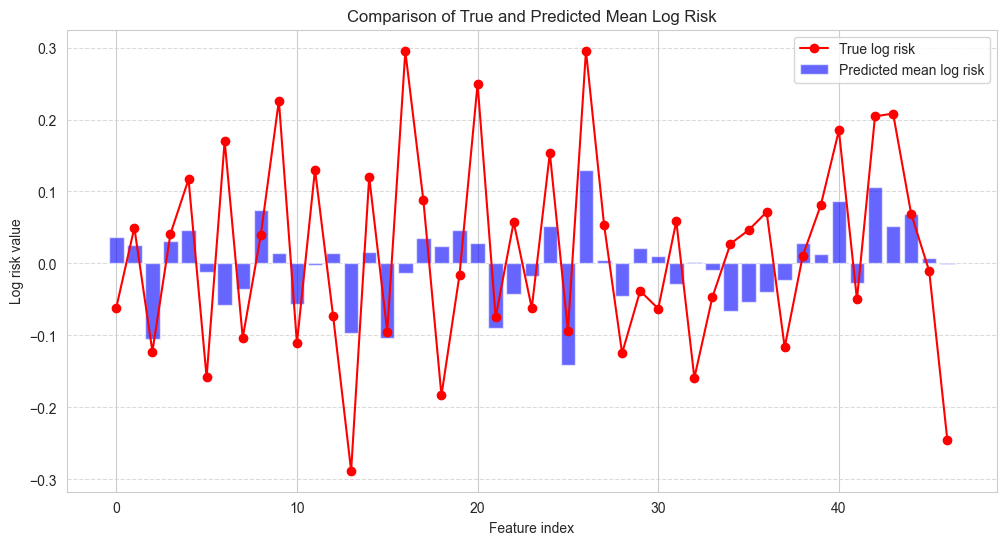

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 test_size 和 真实数据 theta_true, posterior_means 已经从代码中得到
test_size = 100  # 这里可以改成实际的 test_size
num_features = 47  # log_risk 变量的维度

# 真实值和预测值
log_risk_true = theta_true[:, :num_features].numpy()  # shape [test_size, 47]
log_risk_infer = posterior_means[:, :num_features]  # shape [test_size, 47]

# 计算每个维度的均值
log_risk_true_mean = log_risk_true.mean(axis=0)
log_risk_infer_mean = log_risk_infer.mean(axis=0)


# 画图
plt.figure(figsize=(12, 6))
x = np.arange(num_features)

# 画真实值的折线图
plt.plot(x, log_risk_true_mean, color='red', marker='o', linestyle='-', label="True log risk")

# 画预测值的柱状图
plt.bar(x, log_risk_infer_mean, alpha=0.6, color='blue', label="Predicted mean log risk")

# 添加标签
plt.xlabel("Feature index")
plt.ylabel("Log risk value")
plt.title("Comparison of True and Predicted Mean Log Risk")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# 显示图表
plt.show()


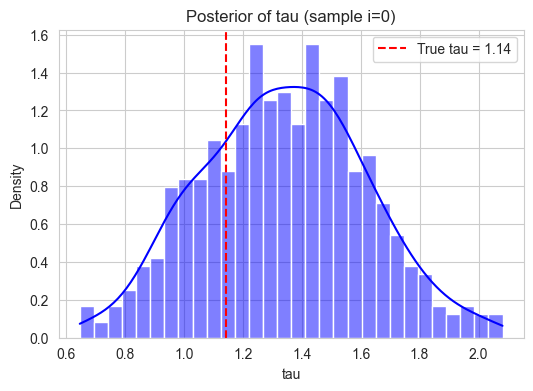

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 提取最后一维 (tau) 的采样值
tau_samples = theta_samples[..., -1]  # => [test_size, n_samples]

i = 0  # 想查看第0个测试样本的后验分布

# tau 的真实值
tau_true = test_batch["parameters"][i, -1]  # => 标量
# tau 的后验采样
tau_samples_i = tau_samples[i]             # => shape [n_samples]

# 画图
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(tau_samples_i, ax=ax, kde=True, color='blue', bins=30, stat='density')
ax.axvline(tau_true, color='red', linestyle='--', label=f"True tau = {tau_true:.2f}")
ax.set_title(f"Posterior of tau (sample i={i})")
ax.set_xlabel("tau")
ax.legend()
plt.show()


In [20]:
import subprocess

# 检查最新的 BayesFlow 版本
latest_version_cmd = "pip index versions bayesflow"
latest_version_result = subprocess.run(latest_version_cmd, shell=True, capture_output=True, text=True)

# 检查当前安装的 BayesFlow 版本
installed_version_cmd = "pip show bayesflow"
installed_version_result = subprocess.run(installed_version_cmd, shell=True, capture_output=True, text=True)

# 输出版本信息
latest_version_output = latest_version_result.stdout if latest_version_result.returncode == 0 else "Failed to fetch latest version."
installed_version_output = installed_version_result.stdout if installed_version_result.returncode == 0 else "BayesFlow is not installed."

latest_version_output, installed_version_output


('bayesflow (1.1.6)\nAvailable versions: 1.1.6, 1.1.5, 1.1.4, 1.1.3, 1.1.2, 1.1.1\n  INSTALLED: 1.1.6\n  LATEST:    1.1.6\n',
 'Name: bayesflow\nVersion: 1.1.6\nSummary: "Amortizing Bayesian Inference With Neural Networks"\nHome-page: https://github.com/stefanradev93/bayesflow\nAuthor: The BayesFlow Developers\nAuthor-email: \nLicense: MIT\nLocation: /opt/anaconda3/envs/bayesflow/lib/python3.11/site-packages\nRequires: aesara, h5py, matplotlib, numpy, pandas, scikit-learn, scipy, seaborn, tensorflow, tensorflow-probability, tqdm\nRequired-by: \n')

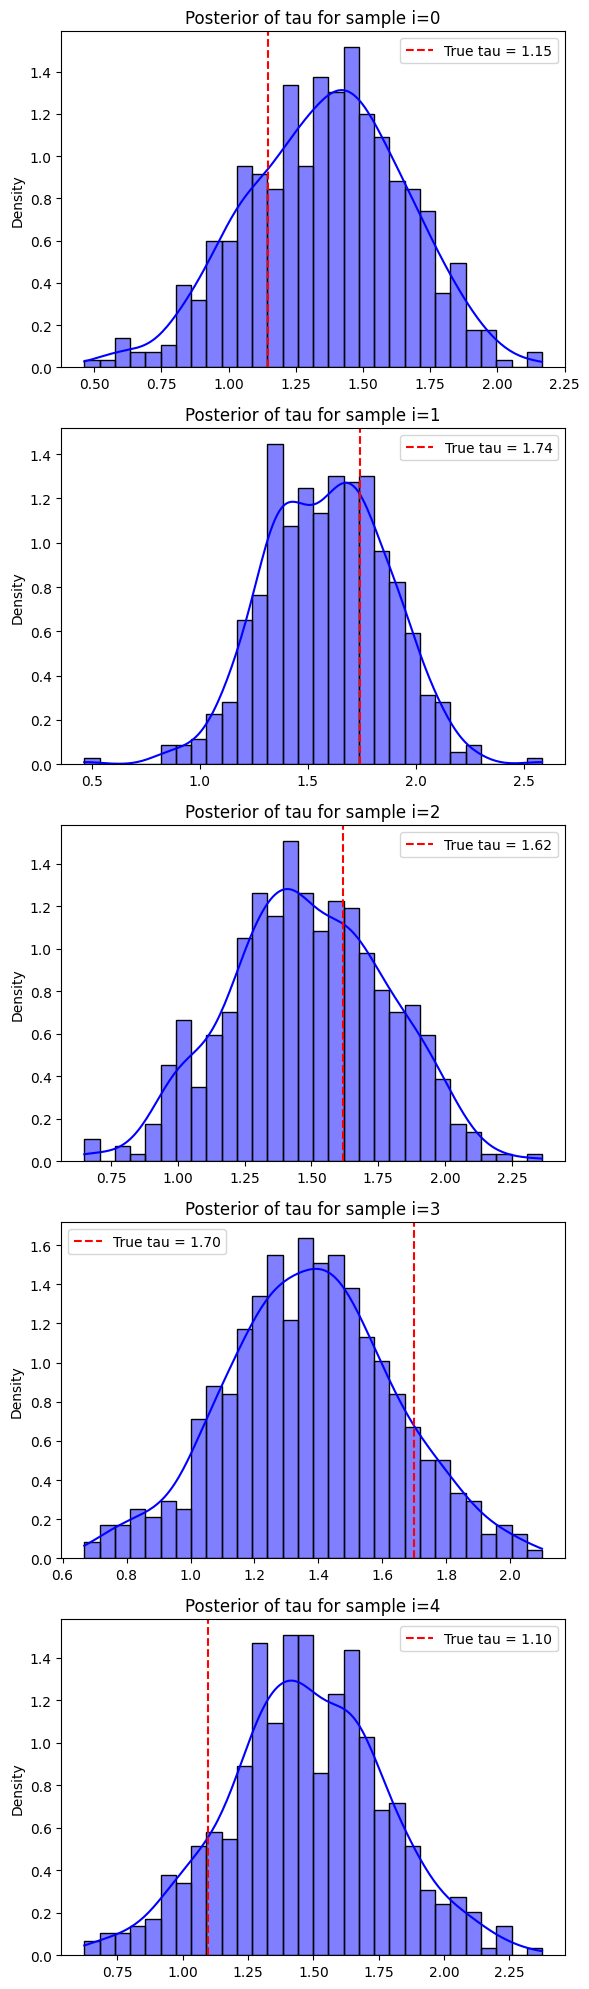

In [20]:
num_to_plot = 5  # 在图上画出前5个测试样本
fig, axes = plt.subplots(num_to_plot, 1, figsize=(6, 4*num_to_plot))

for i in range(num_to_plot):
    ax = axes[i]
    tau_true_i = test_batch["parameters"][i, -1]
    tau_samples_i = tau_samples[i]
    sns.histplot(tau_samples_i, ax=ax, kde=True, color='blue', bins=30, stat='density')
    ax.axvline(tau_true_i, color='red', linestyle='--', label=f"True tau = {tau_true_i:.2f}")
    ax.legend()
    ax.set_title(f"Posterior of tau for sample i={i}")

plt.tight_layout()
plt.show()


In [22]:
# 进行在线训练
history = trainer.train_online(
    epochs=10,                # 总训练轮数
    iterations_per_epoch=500,  # 每轮训练的迭代次数
    batch_size=32,            # 每次训练的样本批量大小
    validation_sims=200       # 验证集样本数量
)


INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [02:22<00:00,  3.51it/s, Epoch: 1, Iter: 500,Loss: 68.993,W.Decay: 0.257,Avg.Loss: 68.381,Avg.W.Decay: 0.260,LR: 4.82E-04]
INFO:root:Validation, Epoch: 1, Loss: 68.118
Training epoch 2: 100%|██████████| 500/500 [02:20<00:00,  3.56it/s, Epoch: 2, Iter: 500,Loss: 65.046,W.Decay: 0.254,Avg.Loss: 67.150,Avg.W.Decay: 0.256,LR: 4.41E-04]
INFO:root:Validation, Epoch: 2, Loss: 66.928
Training epoch 3: 100%|██████████| 500/500 [02:20<00:00,  3.55it/s, Epoch: 3, Iter: 500,Loss: 66.370,W.Decay: 0.252,Avg.Loss: 66.185,Avg.W.Decay: 0.253,LR: 3.82E-04]
INFO:root:Validation, Epoch: 3, Loss: 65.713
Training epoch 4: 100%|██████████| 500/500 [02:17<00:00,  3.63it/s, Epoch: 4, Iter: 500,Loss: 64.368,W.Decay: 0.249,Avg.Loss: 65.151,Avg.W.Decay: 0.251,LR: 3.10E-04]
INFO:root:Validation, Epoch: 4, Loss: 64.416
Training epoch 5: 100%|██████████| 500/500 [02:17<00:00,  3.63it/s, Epoch: 5, Iter: 500,Loss: 61.757,W.D

In [23]:
# 生成测试数据
test_size = 100
test_batch = model(batch_size=test_size)
test_batch = simple_configurator(test_batch)

# 分离一下真实参数、观测数据
theta_true = test_batch["parameters"]           # => [test_size, 48]
x_test     = test_batch["summary_conditions"]   # => [test_size, n_obs, 47]

# 后验采样
theta_samples = amortizer.sample(
    {"summary_conditions": x_test},  # 或直接用 test_batch 也行
    n_samples=500,
    to_numpy=True
)
# => [test_size, 500, 48]

# 取均值 => [test_size, 48]
posterior_means = theta_samples.mean(axis=1)

# 比较 tau 部分 vs 真值
tau_true  = theta_true[:, -1].numpy()         # shape [test_size]
tau_infer = posterior_means[:, -1]            # shape [test_size]
mse_tau = np.mean((tau_infer - tau_true)**2)
print("MSE of tau =", mse_tau)

# 也可比较 log_risk(前47维)
mse_log_risk = np.mean( (posterior_means[:, :47] - theta_true[:, :47].numpy())**2 )
print("MSE of log_risk =", mse_log_risk)


MSE of tau = 0.0688132
MSE of log_risk = 1.1811966


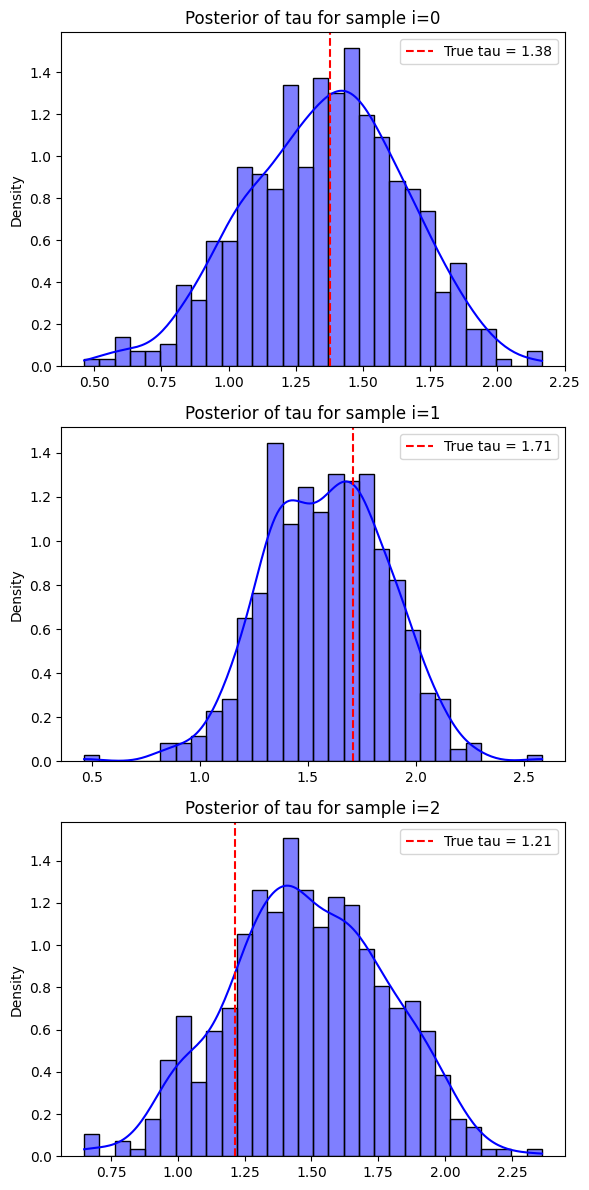

In [25]:
num_to_plot = 3 # 在图上画出前5个测试样本
fig, axes = plt.subplots(num_to_plot, 1, figsize=(6, 4*num_to_plot))

for i in range(num_to_plot):
    ax = axes[i]
    tau_true_i = test_batch["parameters"][i, -1]
    tau_samples_i = tau_samples[i]
    sns.histplot(tau_samples_i, ax=ax, kde=True, color='blue', bins=30, stat='density')
    ax.axvline(tau_true_i, color='red', linestyle='--', label=f"True tau = {tau_true_i:.2f}")
    ax.legend()
    ax.set_title(f"Posterior of tau for sample i={i}")

plt.tight_layout()
plt.show()
